# Robust Neural Network: 2D toy example

In this example, we train a simple network that is robust to adversarial noise. 

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

from voting import matrix_op_robust_voting

import sys
sys.path.append("../")
from convex_adversarial import robust_loss, robust_loss_parallel
from trainer import robust_loss_cascade, sampler_robust_cascade


%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

import sklearn
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from pandas import DataFrame

In [117]:
# random points at least 2r apart
m = 100
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.15
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > r/2:
        x.append(p)
# r = 0.145
epsilon = r/4

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

## Baseline: cross entropy loss

In [118]:
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    if i % 100 == 0:
        print(l.data, err)
    opt.zero_grad()
    (l).backward()
    opt.step()
print(l.data)

tensor(0.6947) tensor(0.5100)
tensor(0.5615) tensor(0.2900)
tensor(0.3998) tensor(0.1300)
tensor(0.2868) tensor(0.1000)
tensor(0.2143) tensor(0.0600)
tensor(0.1586) tensor(0.0500)
tensor(0.1209) tensor(0.0100)
tensor(0.0810) tensor(0.0100)
tensor(0.0721) tensor(0.0100)
tensor(0.0524) tensor(0.)
tensor(0.0421)


### Visualization: learned baseline classifier 

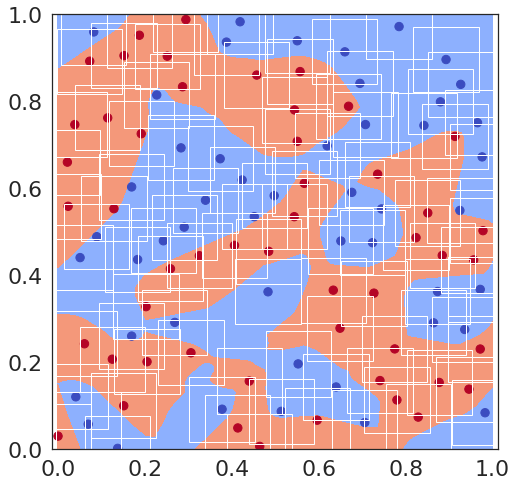

In [119]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

Y0 = torch.argmax(y0, dim=1).long()


fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

plt.show()

## Robust Neural Network

In [120]:
import sys
sys.path.append("../")
from convex_adversarial import robust_loss

torch.manual_seed(1)
robust_net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
data = []
opt = optim.Adam(robust_net.parameters(), lr=1e-3)
for i in range(1000):
    robust_ce, robust_err = robust_loss(robust_net, epsilon, X, y)
    out = robust_net(X)
    l2 = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    data.append([l2.data, robust_ce.data, err, robust_err])
    if i % 100 == 0:
        print(robust_ce.data, robust_err)
    opt.zero_grad()
    (robust_ce).backward()
    opt.step()

print(l2.data, robust_ce.data, robust_err)

tensor(0.6937) 0.49
tensor(0.6763) 0.44
tensor(0.6716) 0.46
tensor(0.6694) 0.45
tensor(0.6682) 0.44
tensor(0.6673) 0.44
tensor(0.6666) 0.41
tensor(0.6661) 0.44
tensor(0.6649) 0.43
tensor(0.6639) 0.45
tensor(0.6110) tensor(0.6636) 0.43


In [121]:
def get_robust_model(seed=1, epochs=100):
    torch.manual_seed(seed)
    robust_net = nn.Sequential(
        nn.Linear(2,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,2)
    )
    data = []
    opt = optim.Adam(robust_net.parameters(), lr=1e-3)
    for i in range(epochs):
        robust_ce, robust_err = robust_loss(robust_net, epsilon, X, y)
        out = robust_net(X)
        l2 = nn.CrossEntropyLoss()(out, Variable(y))
        err = (out.max(1)[1].data != y).float().mean()
        data.append([l2.data, robust_ce.data, err, robust_err])
        opt.zero_grad()
        (robust_ce).backward()
        opt.step()
    
#     print(l2.data, robust_ce.data, robust_err)
    
    print(f"CRA: {1-robust_err}")
        
    return robust_net


get_model = lambda : nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

def train_robust_model(f, dataloader, epochs=100):
    
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(f.parameters(), lr=1e-3)
    for _ in range(epochs):
        for features, labels in dataloader:
            features = features.cuda()
            labels = labels.cuda()
            robust_ce, robust_err = robust_loss(f, epsilon, features, labels)
            out = f(features)
            l2 = loss_fn(out, Variable(labels))
            err = (out.max(1)[1].data != labels).float().mean()
            data.append([l2.data, robust_ce.data, err, robust_err])
            opt.zero_grad()
            (robust_ce).backward()
            opt.step()
    
#     print(l2.data, robust_ce.data, robust_err)
    
#     print(f"CRA: {1-robust_err}")
        
    return f

def cascad_training(epochs=50, max_models=5):

    sampler_indices = []
    model = []
    
    dataset = torch.utils.data.TensorDataset(X, y)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=50)
    
    for _ in range(max_models): 
        # reduce dataset to just uncertified examples
        
        model.append(train_robust_model(get_model().cuda(), trainloader, epochs=80))
        
#         robust_ce, robust_err = robust_loss(model[-1], epsilon, X, y)
        
        print("Reducing dataset...")
        trainloader = sampler_robust_cascade(trainloader, model, epsilon,
                                              128, bounded_input=True)
        if trainloader is None: 
            print('No more examples, terminating')
            break
        sampler_indices.append(trainloader.sampler.indices)

    return model

In [125]:
models = cascad_training(max_models=5)

Reducing dataset...
Certifying minibatch 0/1 [current total: 0/100]
Reducing dataset...
Certifying minibatch 0/1 [current total: 0/100]
Reducing dataset...
Certifying minibatch 0/1 [current total: 0/100]
No more examples, terminating


In [126]:
m1 = models[0].cpu()
m2 = models[1].cpu()
m3 = models[2].cpu()

In [ ]:
models

### Visualization: learned robust classifier

In [127]:

N = 200
XX, YY = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = robust_net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(N,N).data.numpy()
Y0 = torch.argmax(y0, dim=1).long()

batch_size = 512
certificates = []
for i in range(0, X0.shape[0], batch_size):
    x1 = X0[i:i+batch_size]
    y1 = Y0[i:i+batch_size]
    _, _, c = robust_loss(robust_net, epsilon, x1, y1, return_certificate=True)
    certificates.append(c)

certificates = torch.cat(certificates, dim=0)
Y0 = Y0.resize(N, N)
certificates = certificates.resize(N, N)



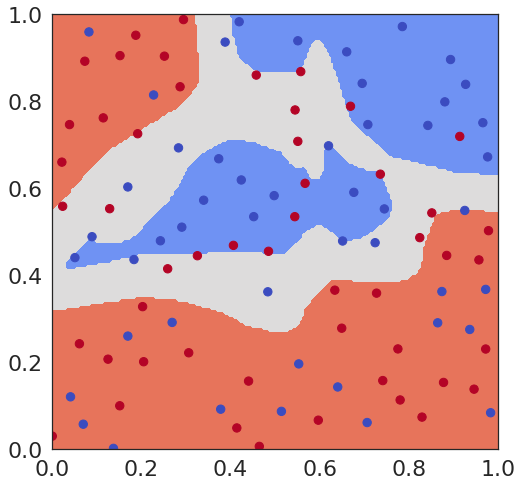

In [128]:

Y0 *= 2
ZZ = torch.where(certificates == True, Y0, torch.zeros((N, N)).long()+1)

fig, ax = plt.subplots(figsize=(8,8))
# print(np.unique(ZZ, return_counts=True))

ax.contourf(XX,YY, ZZ, cmap="coolwarm", levels=2)

ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
# ax.axis("equal")
# ax.axis([0,1,0,1])

# for a in x:
#     ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
plt.savefig("")
plt.show()

### Visualize decision boundary for ensemble candidates

In [129]:
def get_robust_predictions(XX, YY, m, N = 200):
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = m(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(N,N).data.numpy()
    
    Y0 = torch.argmax(y0, dim=1).long()
    
    batch_size = 512
    certificates = []
    for i in range(0, X0.shape[0], batch_size):
        x1 = X0[i:i+batch_size]
        y1 = Y0[i:i+batch_size]
        _, _, c = robust_loss(robust_net, epsilon, x1, y1, return_certificate=True)
        certificates.append(c)

    Y0 = Y0.resize(N, N)
    certificates = torch.cat(certificates, dim=0)

    return Y0, certificates.resize(N,N).data

In [130]:
XX, YY = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))

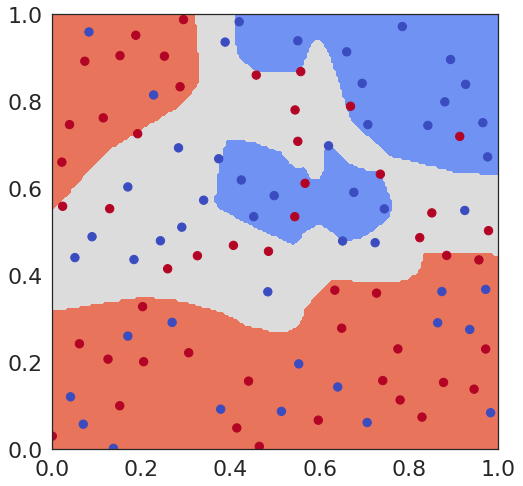

In [134]:
ZZ1, C1 = get_robust_predictions(XX, YY, m1)

ZZ1 *= 2
ZZ1 = torch.where(C1 == True, ZZ1, torch.zeros((N, N)).long()+1)

fig, ax = plt.subplots(figsize=(8,8))
# print(np.unique(ZZ, return_counts=True))

ax.contourf(XX, YY, ZZ1, cmap="coolwarm", levels=2)

ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
# ax.axis("equal")
# ax.axis([0,1,0,1])

# for a in x:
#     ax.add_patch(patches.Rectangle((a[0]-r/4, a[1]-r/4), r/2, r/2, fill=False))
# # plt.savefig("")
plt.show()

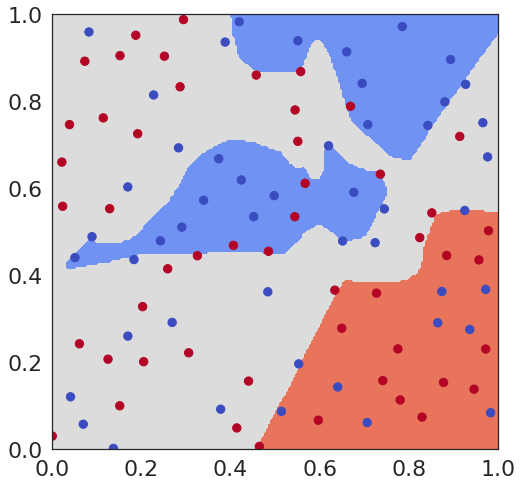

In [135]:
ZZ2, C2 = get_robust_predictions(XX, YY, m2)

ZZ2 *= 2
ZZ2 = torch.where(C2 == True, ZZ2, torch.zeros((N, N)).long()+1)

fig, ax = plt.subplots(figsize=(8,8))
# print(np.unique(ZZ, return_counts=True))

ax.contourf(XX, YY, ZZ2, cmap="coolwarm", levels=2)

ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
# ax.axis("equal")
# ax.axis([0,1,0,1])

# for a in x:
#     ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
# plt.savefig("")
plt.show()

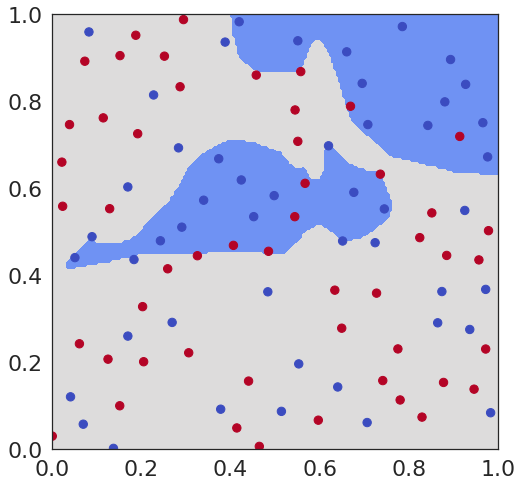

In [138]:
ZZ3, C3 = get_robust_predictions(XX, YY, m3)

ZZ3 *= 2
ZZ3 = torch.where(C3 == True, ZZ3, torch.zeros((N, N)).long()+1)

fig, ax = plt.subplots(figsize=(8,8))
# print(np.unique(ZZ, return_counts=True))

ZZ3[0, 0] = 2
ax.contourf(XX, YY, ZZ3, cmap="coolwarm", levels=2)

ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
# ax.axis("equal")
# ax.axis([0,1,0,1])

# for a in x:
#     ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
# plt.savefig("")
plt.show()

In [139]:
def cascade(y_pred, certified):
    predictions = []
    certificates = []
    for i in range(np.shape(y_pred)[1]):
        certified_yet = False
        for j in range(np.shape(y_pred)[0]-1):
            if certified[j][i] == 1 and not certified_yet:
                predictions.append(y_pred[j][i])
                certificates.append(1)
                certified_yet = True
                
            
        if not certified_yet:
            predictions.append(y_pred[np.shape(y_pred)[0]-1][i])
            certificates.append(certified[np.shape(y_pred)[0]-1][i])

    return predictions, certificates


In [153]:
y_pred = np.array([ZZ1.flatten().numpy(), ZZ2.flatten().numpy(), ZZ3.flatten().numpy()])
certified = np.array([C1.flatten().numpy(), C2.flatten().numpy(), C3.flatten().numpy()])

In [154]:
y_pred

array([[2, 2, 2, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0]])

In [155]:
certified

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [156]:
cas_ZZ, cas_CC = cascade(y_pred, certified)
cas_ZZ = np.array(cas_ZZ).reshape((N, N))
cas_CC = np.array(cas_CC).reshape((N, N))

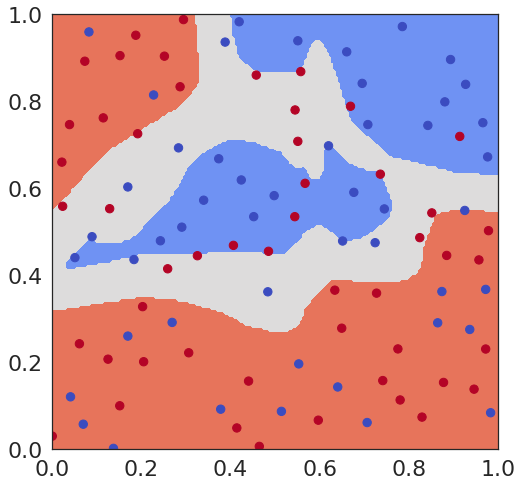

In [157]:
# casZZ, casC = get_robust_predictions(XX, YY, m1)

cas_ZZ = np.where(cas_CC == 1, cas_ZZ, torch.zeros((N, N)).long()+1)

fig, ax = plt.subplots(figsize=(8,8))
# print(np.unique(ZZ, return_counts=True))

ax.contourf(XX, YY, cas_ZZ, cmap="coolwarm", levels=2)

ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
# ax.axis("equal")
# ax.axis([0,1,0,1])

# for a in x:
#     ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
# plt.savefig("")
plt.show()

In [160]:
ens_ZZ, _, vote_acc, vote_vra, weights = matrix_op_robust_voting(
    y_pred,
    np.ones((N*N,)),
    certified.astype(np.int32),
    solve_for_weights=False,
    num_classes=2,
    weights=None)

ens_ZZ = ens_ZZ.reshape((N, N))

IndexError: index 2 is out of bounds for axis 0 with size 2

NameError: name 'ens_ZZ' is not defined

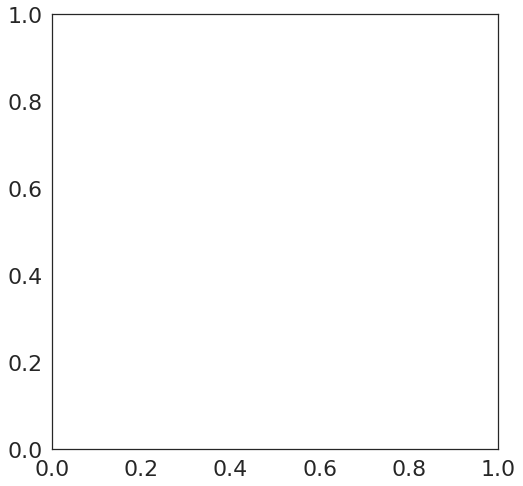

In [146]:
fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY, ens_ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

In [64]:
ens_ZZ, _, vote_acc, vote_vra, weights = matrix_op_robust_voting(
    y_pred,
    np.ones((100*100,)),
    certified,
    solve_for_weights=True,
    num_classes=2,
    weights=None)

ens_ZZ = ens_ZZ.reshape((100, 100))

1000/1000 [==============================] - 8s 6ms/step - loss: -0.5000 - margin: -0.6870 - w0: 4.7141 - w1: -1.3538 - w2: -1.2512


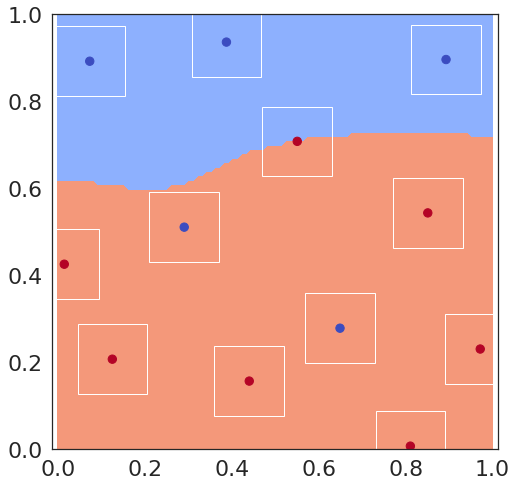

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX, YY, ens_ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

# Grid plots

In [11]:
def plot_grid(net, ax): 
    XX, YY = np.meshgrid(np.linspace(-0.1, 1.1, 100), np.linspace(-0.1, 1.1, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = net(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
    ax.axis("equal")
    ax.axis([0,1,0,1])

    for a in x:
        ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
    ax.set_yticks([0.0, 0.5, 1.0])
#     ax.set_xticks([])

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
plot_grid(net, axs[0])
plot_grid(robust_net, axs[1])
plt.tight_layout()
plt.savefig('2D_grid.pdf', bbox_inches='tight')

RuntimeError: adjustable='datalim' is not allowed when both axes are shared

RuntimeError: adjustable='datalim' is not allowed when both axes are shared

<Figure size 576x288 with 2 Axes>

# Learning curves

In [ ]:
seaborn.set_style("whitegrid")
d = np.array(data)
fig, ax_loss = plt.subplots(1,1,figsize=(4,4))
ax_loss.plot(d[:,0], color='C0')
ax_loss.plot(d[:,1], color='C1')
ax_err = ax_loss.twinx()
ax_err.plot(d[:,2], color='C2')
ax_err.plot(d[:,3], color='C3')

In [ ]:
seaborn.set_style("whitegrid")
d = np.array(data)
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].semilogy(d[:,0], color='C0')
axs[0].semilogy(d[:,1], color='C1')
axs[1].plot(d[:,2], color='C2')
axs[1].plot(d[:,3], color='C3')
plt.tight_layout()
plt.savefig('2D_curves.pdf', bbox_inches='tight')

In [ ]:

ax1 = plt.plot()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
plt.plot(t,s1,'b-')
plt.xlabel('t (s)')
plt.ylabel('exp',color='b')

ax2 = ax1.twinx()
s2 = np.sin(2*np.pi*t)
ax2.plot(t, s2, 'r.')
plt.ylabel('sin', color='r')
plt.show()